# 05: Gradients and Activation Functions

Possible structure:

- Vanishing gradients
  - Sigmoid
  - through backprop
  
- ReLu
  - (leaky ReLu) - maybe
  
- Exploding gradients
  - weight initialisation
  - gradient clipping

- (Normalisation?) - maybe
  - (Tanh)
  - (Batch norm)

- What activation function to use
  - output layer
  - hidden layers


## Activation Functions: Recap

Remember that the activation function, $g(z)$, is applied to the linear combination of a node's inputs, $z$:

$$
\mathbf{A}^{[l]} = g(\mathbf{Z}^{[l]})
$$

And so far we have seen two different activation functions:

- **Linear activation:** $g(\mathbf{Z}^{[l]}) = \mathbf{Z}^{[l]}$
  - Output layer: Used for regression problems
  - Hidden layers: Usually not used (as then only linear functions can be fitted)
- **Sigmoid activation:** $g(\mathbf{Z}^{[l]}) = \mathrm{sigmoid}\left(\mathbf{Z}^{[l]}\right) = \sigma\left(\mathbf{Z}^{[l]}\right)$
  - Output layer: Used for (binary) classification problems
  - Hidden layers: _Can_ be used to fit non-linear functions, but generally not used (we'll see why later)
  
To compute the $\color{blue}{\partial \mathbf{A}^{[l]} / \partial \mathbf{Z}^{[l]}}$ terms we need to know the derivative of the activation function.

## Repeating Terms in Back Propagation

As an example, let's consider a four-layer network:

![](../img/05_4layers.png)

Each layer is represented by only one node in the diagram (but can actually contain many nodes without changing the equation below).

Here is the loss-gradient for the weights in the **first** layer of the **four**-layer network, in matrix notation:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[1]}} =
\frac{1}{m}
\left\{
\color{red}{\mathbf{W}^{[2]^T}}
\left(
\color{red}{\mathbf{W}^{[3]^T}}
\left[
\color{red}{\mathbf{W}^{[4]^T}}
\left\{
\frac{\partial \mathcal{L}}{\partial \mathbf{A}^{[4]}} * \color{blue}{\frac{\partial \mathbf{A}^{[4]}}{\partial \mathbf{Z}^{[4]}}}
\right\}
* \color{blue}{\frac{\partial \mathbf{A}^{[3]}}{\partial \mathbf{Z}^{[3]}}}
\right]
* \color{blue}{\frac{\partial \mathbf{A}^{[2]}}{\partial \mathbf{Z}^{[2]}}}
\right) * \color{blue}{\frac{\partial \mathbf{A}^{[1]}}{\partial \mathbf{Z}^{[1]}}}
\right\}
\mathbf{A}^{[0]^T}
$$

where two groups of similar terms are highlighted:

- $\color{blue}{\partial \mathbf{A}^{[l]} / \partial \mathbf{Z}^{[l]}}$: <span style="color:blue">The gradient of the node activations in a layer (with respect to the node's inputs)</span>.
- $\color{red}{\mathbf{W}^{[l]^T}}$: <span style="color:red">The weights in a layer</span>.

and the other terms are:

- $\partial \mathcal{L} / \partial \mathbf{A}^{[4]} = \partial \mathcal{L} / \partial \mathbf{\hat{y}}$: The gradient of the loss with respect to our predictions (aka the activations of the last, in this case the fourth, layer)
- $\mathbf{A}^{[0]^T} = \mathbf{X}^T$: The input data (aka the activations of the zeroth layer).
- $1/m$: To take the mean gradient across the data batch (which has $m$ samples)

In this notebook, we're going to focus on how, in certain situations, the form of this equation can make it difficult to learn (optimise) the weights of the network, and in particular the weights in the early layers of a deep network.

## The Gradient of the Sigmoid Function

We're going to start by considering the activation gradient terms ($\color{blue}{\partial \mathbf{A}^{[l]} / \partial \mathbf{Z}^{[l]}}$) above. 

The sigmoid function, $\sigma(z)$, is defined as:

$$
\sigma(z) = \frac{1}{1 + \exp(-z)}
$$

and its derivative is:

$$
\frac{\mathrm{d}\sigma}{\mathrm{d}z} = \sigma(z) \left[1 - \sigma(z) \right]
$$

They look like this:

Text(0.5, 1.0, 'Gradient')

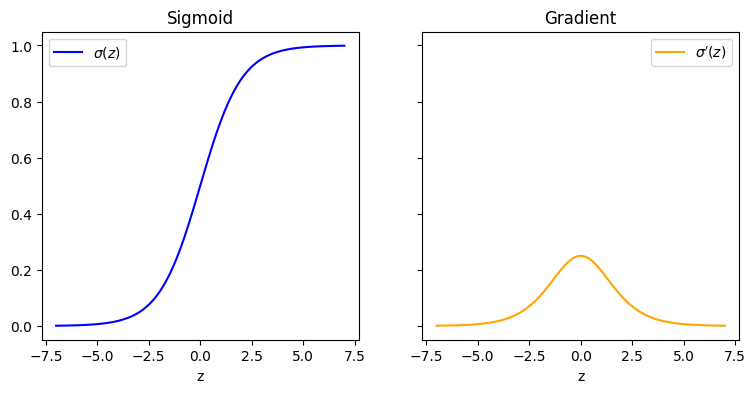

In [247]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def dsigmoid_dz(z):
    return sigmoid(z) * (1 - sigmoid(z))


z = np.linspace(-7, 7, 100)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].plot(z, sigmoid(z), color="b", label=r"$\sigma(z)$")
ax[0].legend()
ax[0].set_xlabel("z")
ax[0].set_title("Sigmoid")
ax[1].plot(z, dsigmoid_dz(z), color="orange", label=r"$\sigma'(z)$")
ax[1].legend()
ax[1].set_xlabel("z")
ax[1].set_title("Gradient")


Note that:

- The maximum gradient of the sigmoid function is 0.25 ($0 \leq \mathrm{d}\sigma / \mathrm{d}z \leq 0.25$)
- The gradient is close to zero for most values of $z$ (especially for $z < -5$ and $z > 5$)



## Vanishing Gradients

To help gain intuition, let's consider the case where:

- our four-layer example network really does only have one node per layer
- all the weights are one ($\mathbf{W}^{[1]} = \mathbf{W}^{[2]} = \mathbf{W}^{[3]} = \mathbf{W}^{[4]} = 1$)
- all the biases are zero ($\mathbf{b}^{[1]} = \mathbf{b}^{[2]} = \mathbf{b}^{[3]} = \mathbf{b}^{[4]} = 0$)
- there's only one input ($x$).

In this case the network computes:

$$
\mathbf{A^{[0]}} = \mathbf{Z}^{[1]} = x \\
\mathbf{A^{[1]}} = \mathbf{Z}^{[2]} = \sigma(x) \\
\mathbf{A^{[2]}} = \mathbf{Z}^{[3]} = \sigma(\sigma(x)) \\
\mathbf{A^{[3]}} = \mathbf{Z}^{[4]} = \sigma(\sigma(\sigma(x))) \\
\mathbf{A^{[4]}} = \hat{y} = \sigma(\sigma(\sigma((x)))) \\
$$

And the loss gradient for the weights in each layer (for one data sample $x$) are:


$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[4]}} =
\frac{\partial \mathcal{L}}{\partial \mathbf{A}^{[4]}}
\color{blue}{\frac{\partial \mathbf{A}^{[4]}}{\partial \mathbf{Z}^{[4]}}}
\mathbf{A}^{[3]}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[3]}} =
\frac{\partial \mathcal{L}}{\partial \mathbf{A}^{[4]}}
\color{blue}{\frac{\partial \mathbf{A}^{[4]}}{\partial \mathbf{Z}^{[4]}}}
\color{blue}{\frac{\partial \mathbf{A}^{[3]}}{\partial \mathbf{Z}^{[3]}}}
\mathbf{A}^{[2]}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[2]}} =
\frac{\partial \mathcal{L}}{\partial \mathbf{A}^{[4]}}
\color{blue}{\frac{\partial \mathbf{A}^{[4]}}{\partial \mathbf{Z}^{[4]}}}
\color{blue}{\frac{\partial \mathbf{A}^{[3]}}{\partial \mathbf{Z}^{[3]}}}
\color{blue}{\frac{\partial \mathbf{A}^{[2]}}{\partial \mathbf{Z}^{[2]}}}
\mathbf{A}^{[1]}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[1]}} =
\frac{\partial \mathcal{L}}{\partial \mathbf{A}^{[4]}}
\color{blue}{\frac{\partial \mathbf{A}^{[4]}}{\partial \mathbf{Z}^{[4]}}}
\color{blue}{\frac{\partial \mathbf{A}^{[3]}}{\partial \mathbf{Z}^{[3]}}}
\color{blue}{\frac{\partial \mathbf{A}^{[2]}}{\partial \mathbf{Z}^{[2]}}}
\color{blue}{\frac{\partial \mathbf{A}^{[1]}}{\partial \mathbf{Z}^{[1]}}}
x
$$

Assuming log loss:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{A}^{[4]}}
\color{blue}{\frac{\partial \mathbf{A}^{[4]}}{\partial \mathbf{Z}^{[4]}}} = \mathbf{A}^{[4]} - y
$$

Text(0.5, 1.0, 'Layer Loss-Gradients ($\\partial \\mathcal{L} / \\partial W^{[l]}$) if $y = 0$')

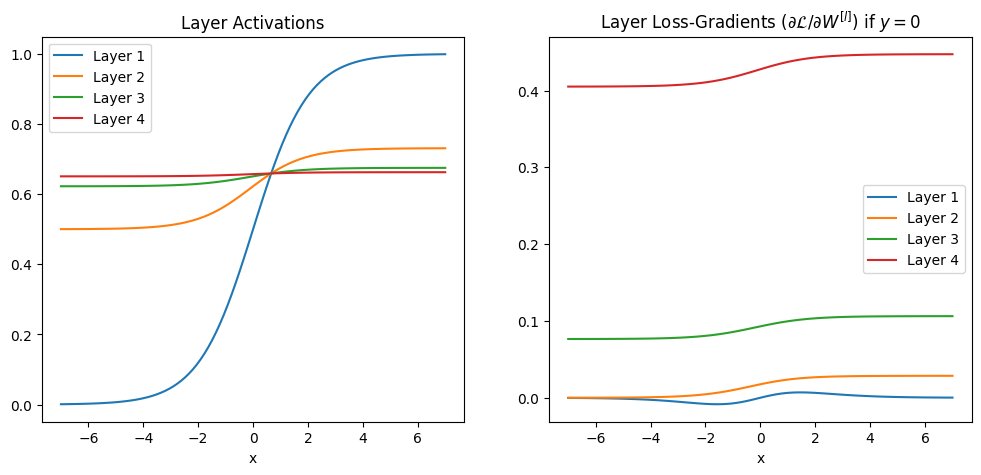

In [267]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 5))


def activations_gradients(x, y, layers, g, dg_dz, dL_dyhat):

    activations = [x]
    for l in range(1, layers):
        activations.append(g(activations[-1]))
    ...

a1 = sigmoid(x)
a2 = sigmoid(a1)
a3 = sigmoid(a2)
a4 = sigmoid(a3)

dL_dZ4 = a4 - y
dL_dW4 = dL_dZ4 * a3
dL_dZ3 = dL_dZ4 * dsigmoid_dz(a2)
dL_dW3 = dL_dZ3 * a2
dL_dZ2 = dL_dZ3 * dsigmoid_dz(a1)
dL_dW2 = dL_dZ2 * a1
dL_dZ1 = dL_dZ2 * dsigmoid_dz(x)
dL_dW1 = dL_dZ1 * x


    

x = np.linspace(-7, 7, 100)

ax[0].plot(x, a1, label="Layer 1")
ax[0].plot(x, a2, label="Layer 2")
ax[0].plot(x, a3, label="Layer 3")
ax[0].plot(x, a4, label="Layer 4")
ax[0].legend()
ax[0].set_xlabel("x")
ax[0].set_title("Layer Activations")

ax[1].plot(x, dL_dW1, label="Layer 1")
ax[1].plot(x, dL_dW2, label="Layer 2")
ax[1].plot(x, dL_dW3, label="Layer 3")
ax[1].plot(x, dL_dW4, label="Layer 4")
ax[1].legend()
ax[1].set_xlabel("x")
ax[1].set_title(
    r"Layer Loss-Gradients ($\partial \mathcal{L} / \partial W^{[l]}$) if $y = 0$"
)

## Why are Vanishing Gradients a Problem?

- We want to train bigger, deeper networks to learn more complex functions
  - We update the weights of the network with gradient descent, computing the derivative of the loss with respect to the weights
    - If the gradients are close to zero in a layer we won't change the weights in those layers
      - With sigmoid activation the gradients get closer and closer to zero as we move back through the layers
        - We stop learning (don't update the weights) in earlier layers!

## ReLU

Text(0.5, 0, 'z')

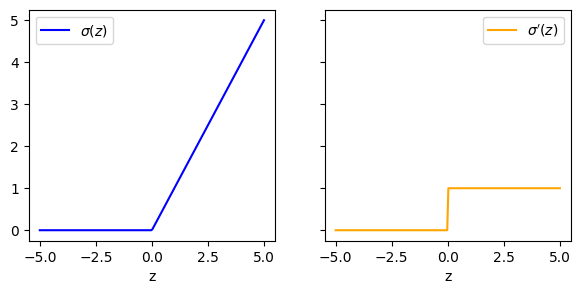

In [11]:
def relu(z):
    r = z.copy()
    r[r < 0] = 0
    return r


def drelu_dz(z):
    dr = z.copy()
    dr[z < 0] = 0
    dr[z >= 0] = 1
    return dr


z = np.linspace(-5, 5, 200)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7, 3))
ax[0].plot(z, relu(z), color="b", label=r"$\sigma(z)$")
ax[0].legend()
ax[0].set_xlabel("z")

ax[1].plot(z, drelu_dz(z), color="orange", label=r"$\sigma'(z)$")
ax[1].legend()
ax[1].set_xlabel("z")

## Exploding Gradients